In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

# For plotting
from matplotlib.colors import ListedColormap


In [2]:
def load_data(file_path):
    # Load the dataset from a CSV file
    data = pd.read_csv(file_path)
    return data

def split_data(data, test_size=0.3):
    X = data.iloc[:, :-1].values  # Features (all columns except last)
    y = data.iloc[:, -1].values   # Target variable (last column)
    
    # Split into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [3]:
class BayesClassifierSharedCov:
    def __init__(self):
        self.mean = None
        self.cov = None
        self.class_priors = None
        
    def fit(self, X_train, y_train):
        n_classes = len(np.unique(y_train))
        self.mean = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
        self.class_priors = np.array([np.mean(y_train == i) for i in range(n_classes)])
        
        # Compute shared covariance matrix (σ²I)
        cov_matrix = np.cov(X_train.T)
        self.cov = cov_matrix + np.eye(X_train.shape[1]) * 1e-5  # Small regularization
    
    def predict(self, X_test):
        n_classes = len(self.class_priors)
        predictions = []
        
        for x in X_test:
            posteriors = []
            for i in range(n_classes):
                mean_diff = x - self.mean[i]
                likelihood = np.exp(-0.5 * mean_diff.dot(np.linalg.inv(self.cov)).dot(mean_diff.T))
                posterior = np.log(self.class_priors[i]) + np.log(likelihood)  # Log of posterior
                posteriors.append(posterior)
                
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)



In [4]:
class BayesClassifierSharedFullCov:
    def __init__(self):
        self.mean = None
        self.cov = None
        self.class_priors = None
        
    def fit(self, X_train, y_train):
        n_classes = len(np.unique(y_train))
        self.mean = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
        self.class_priors = np.array([np.mean(y_train == i) for i in range(n_classes)])
        
        # Compute shared full covariance matrix
        cov_matrices = [np.cov(X_train[y_train == i].T) for i in range(n_classes)]
        self.cov = np.mean(cov_matrices, axis=0)
    
    def predict(self, X_test):
        n_classes = len(self.class_priors)
        predictions = []
        
        for x in X_test:
            posteriors = []
            for i in range(n_classes):
                mean_diff = x - self.mean[i]
                likelihood = np.exp(-0.5 * mean_diff.dot(np.linalg.inv(self.cov)).dot(mean_diff.T))
                posterior = np.log(self.class_priors[i]) + np.log(likelihood)
                posteriors.append(posterior)
                
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)



In [5]:
class BayesClassifierDiagonalCov:
    def __init__(self):
        self.mean = None
        self.cov = None
        self.class_priors = None
        
    def fit(self, X_train, y_train):
        n_classes = len(np.unique(y_train))
        self.mean = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
        self.class_priors = np.array([np.mean(y_train == i) for i in range(n_classes)])
        
        # Compute diagonal covariance matrices for each class
        self.cov = [np.var(X_train[y_train == i], axis=0) for i in range(n_classes)]
    
    def predict(self, X_test):
        n_classes = len(self.class_priors)
        predictions = []
        
        for x in X_test:
            posteriors = []
            for i in range(n_classes):
                mean_diff = x - self.mean[i]
                likelihood = np.prod(np.exp(-0.5 * (mean_diff**2) / self.cov[i]) / np.sqrt(2 * np.pi * self.cov[i]))
                posterior = np.log(self.class_priors[i]) + np.log(likelihood)
                posteriors.append(posterior)
                
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)


In [6]:
class BayesClassifierFullCov:
    def __init__(self):
        self.mean = None
        self.cov = None
        self.class_priors = None
        
    def fit(self, X_train, y_train):
        n_classes = len(np.unique(y_train))
        self.mean = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
        self.class_priors = np.array([np.mean(y_train == i) for i in range(n_classes)])
        
        # Compute full covariance matrices for each class
        self.cov = [np.cov(X_train[y_train == i].T) for i in range(n_classes)]
    
    def predict(self, X_test):
        n_classes = len(self.class_priors)
        predictions = []
        
        for x in X_test:
            posteriors = []
            for i in range(n_classes):
                mean_diff = x - self.mean[i]
                likelihood = np.exp(-0.5 * mean_diff.dot(np.linalg.inv(self.cov[i])).dot(mean_diff.T))
                posterior = np.log(self.class_priors[i]) + np.log(likelihood)
                posteriors.append(posterior)
                
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)


In [7]:
def compute_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    return conf_matrix, accuracy, precision, recall, f1

def plot_decision_boundary(X_train, y_train, classifier, title):
    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', s=50)
    plt.title(title)
    plt.show()

    

Confusion Matrix:
[[146   0   2]
 [  3 138   0]
 [  3   0 158]]
Accuracy: 0.9822222222222222
Precision: [0.96052632 1.         0.9875    ]
Recall: [0.98648649 0.9787234  0.98136646]
F1 Score: [0.97333333 0.98924731 0.98442368]


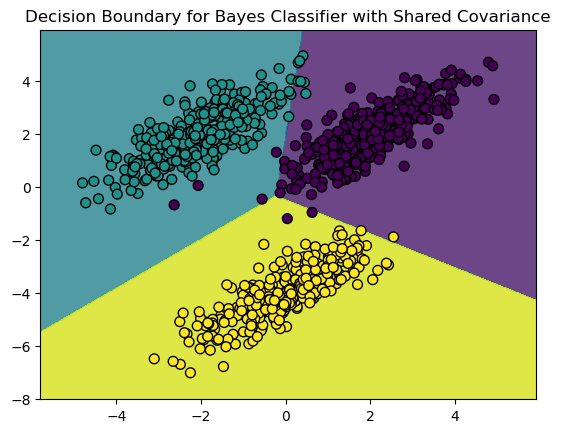

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Generate synthetic data: 3 classes, 2 features (linearly separable)
np.random.seed(100)

# Parameters
n_samples_per_class = 500
n_features = 2
n_classes = 3

# Class means (centroids for each class)
class_means = np.array([[2, 2], [-2, 2], [0, -4]])

# Covariance matrix (same for all classes, just for illustration)
covariance = np.array([[1, 0.8], [0.8, 1]])

# Generate data
X = []
y = []

for i in range(n_classes):
    # Generate data for each class with mean and covariance
    X_class = np.random.multivariate_normal(class_means[i], covariance, n_samples_per_class)
    y_class = np.full(n_samples_per_class, i)
    
    X.append(X_class)
    y.append(y_class)

# Convert to numpy arrays
X = np.vstack(X)
y = np.hstack(y)

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Bayes Classifier with Shared Covariance Matrix
class BayesClassifierSharedCov:
    def __init__(self):
        self.mean = None
        self.cov = None
        self.class_priors = None
        
    def fit(self, X_train, y_train):
        n_classes = len(np.unique(y_train))
        self.mean = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
        self.class_priors = np.array([np.mean(y_train == i) for i in range(n_classes)])
        
        # Compute shared covariance matrix (σ²I)
        cov_matrix = np.cov(X_train.T)
        self.cov = cov_matrix + np.eye(X_train.shape[1]) * 1e-5  # Small regularization
    
    def predict(self, X_test):
        n_classes = len(self.class_priors)
        predictions = []
        
        for x in X_test:
            posteriors = []
            for i in range(n_classes):
                mean_diff = x - self.mean[i]
                likelihood = np.exp(-0.5 * mean_diff.dot(np.linalg.inv(self.cov)).dot(mean_diff.T))
                posterior = np.log(self.class_priors[i]) + np.log(likelihood)  # Log of posterior
                posteriors.append(posterior)
                
            predictions.append(np.argmax(posteriors))
        
        return np.array(predictions)

# Initialize the classifier
classifier = BayesClassifierSharedCov()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Compute evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot decision boundary
def plot_decision_boundary(X_train, y_train, classifier, title):
    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', s=50)
    plt.title(title)
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X_train, y_train, classifier, "Decision Boundary for Bayes Classifier with Shared Covariance")


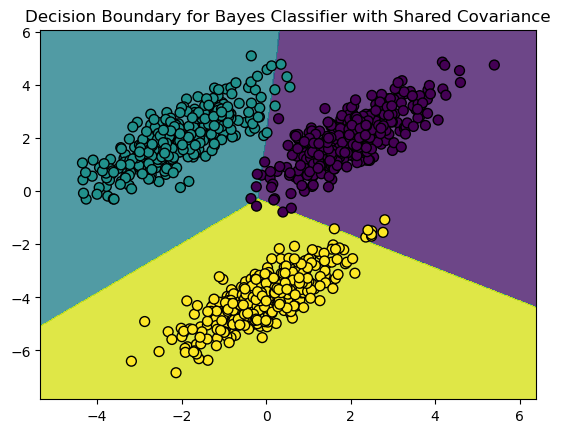

In [11]:
plot_decision_boundary(X_train, y_train, classifier, "Decision Boundary for Bayes Classifier with Shared Covariance")